In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB

In [2]:
train_sm = pd.read_csv("small_train_sm.csv")

In [3]:
train_sm.head()

,Source,Sink,NCA,Exist,Pair,CN,AA,RA,JC,PA,KI,PR
0,1709,2591,0,0,"(1709, 2591)",0,0.0,0.0,0.0,80,0.000046,0.000360
1,1445,3222,0,0,"(1445, 3222)",0,0.0,0.0,0.0,4,0.000002,0.000214
2,395,3684,0,0,"(395, 3684)",0,0.0,0.0,0.0,14,0.000000,0.000235
3,3572,3618,0,0,"(3572, 3618)",0,0.0,0.0,0.0,12,-0.000079,0.000147
4,859,1755,0,0,"(859, 1755)",0,0.0,0.0,0.0,30,0.013973,0.000165


In [4]:
train_sm.shape

(32072, 12)

In [5]:
train_sm.Exist.value_counts()

0    16036
1    16036
Name: Exist, dtype: int64

In [6]:
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

gnb = GaussianNB()

## Node2Vec Features

In [7]:
ds = [15, 20, 25, 30, 35, 40, 45, 50, 55]
auc_n2v = []
for d in ds:
    train = pd.read_csv("small_train_n2v_{}.csv".format(d))
    n2vF = ["n2v_"+str(i+1) for i in range(d)] # node2vec feature list
    X = train[n2vF]
    y = train['Exist']
    
    # Fitting a model with all Node2Vec features
    auc = []
    for train_index, test_index in kf.split(X):
        # split the train data and test data
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
        auc.append(roc_auc_score(y_test, y_pred[:,1]))
    
    auc_n2v.append(mean(auc))
    
auc_n2v = pd.DataFrame(auc_n2v, columns=["AUC"])
auc_n2v.index = ds
auc_n2v

,AUC
15,0.811592
20,0.847048
25,0.874338
30,0.903636
35,0.922357
40,0.927043
45,0.942124
50,0.944963
55,0.947776


## Unweighted Similarity based Features

In [8]:
# unweighted feature list
uwF = ['CN', 'AA', 'RA', 'JC', 'PA', 'KI', 'PR']
X = train_sm[uwF]
y = train_sm['Exist']

auc = []
for train_index, test_index in kf.split(X, y):
    # split the train data and test data
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
    auc.append(roc_auc_score(y_test, y_pred[:,1]))

print("The average AUC is:", mean(auc))

The average AUC is: 0.9871898515999235


## Single Unweighted Similarity Based Features

In [10]:
# Fitting models with single attribute
auc_single = []
for fN in uwF:
    gnb = GaussianNB()
    auc = []
    for train_index, test_index in kf.split(X, y):
        # split the train data and test data
        X_train, X_test = X[[fN]].iloc[train_index,:], X[[fN]].iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
        auc.append(roc_auc_score(y_test, y_pred[:,1]))
    auc_single.append(mean(auc))

auc_single = pd.DataFrame({'Features': uwF, 'AUC': auc_single}).set_index('Features')
auc_single

,AUC
Features,
CN,0.961240
AA,0.962550
RA,0.962878
JC,0.961809
PA,0.753979
KI,0.961263
PR,0.809424


## Weighted Similarity based Features

### Finding the optimal alpha

In [1]:
alphas = [round(a*0.1,1) for a in range(-20, 25)]
weak_ties = ["alphas/weak_ties_{}.csv".format(alpha) for alpha in alphas]

unweighted_train = train_sm[['Pair', 'CN', 'AA', 'RA', 'Exist']]

auc_alpha=[]
for weak_tie in weak_ties:
    weighted_train = pd.read_csv(weak_tie, index_col=0)
    both = unweighted_train.join(weighted_train, on="Pair")
    X = both[['WCN', 'WAA', 'WRA']]
    y = both["Exist"]
    
    auc=[]
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        
        y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
        auc.append(roc_auc_score(y_test, y_pred[:,1]))
    
    auc_alpha.append(mean(auc))

auc_alphaDF = pd.DataFrame(auc_alpha, columns=['AUC'])
auc_alphaDF.index = alphas
auc_alphaDF.head()

NameError: name 'train_sm' is not defined

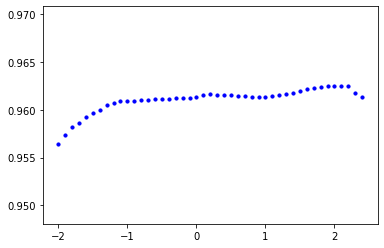

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(auc_alphaDF.index, auc_alphaDF.AUC, s=10, c='b', marker="o")

plt.show()

In [14]:
print('The optimal alpha is {}'.format(auc_alphaDF.AUC.idxmax()))

The optimal alpha is 2.0


### Weighted Features with the optimal alpha (2.0)

In [15]:
# unweighted feature list
alpha = 2.0
wF = ['WCN', 'WAA', 'WRA', 'JC', 'PA', 'KI', 'PR']
weighted_train = pd.read_csv("alphas/weak_ties_{}.csv".format(alpha), index_col=0)
both = train_sm.join(weighted_train, on="Pair")
X = both[wF]
y = both['Exist']

auc = []
for train_index, test_index in kf.split(X, y):
    # split the train data and test data
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
    auc.append(roc_auc_score(y_test, y_pred[:,1]))

print("The average AUC is:", mean(auc))

The average AUC is: 0.9870049652151199


## Node2Vec (45) + Unweighted similarities

In [16]:
d=45
n2vF = ["n2v_"+str(i+1) for i in range(d)]
uwF = ['CN', 'AA', 'RA', 'JC', 'PA', 'KI', 'PR']

train_n2v = pd.read_csv("small_train_n2v_{}.csv".format(d))
train_n2v = train_n2v[n2vF+["Pair"]]

train_uw = pd.read_csv("small_train_sm.csv")

combined = train_uw.join(train_n2v.set_index("Pair"), on="Pair")

X = combined[uwF+n2vF]
y = combined['Exist']

auc = []
for train_index, test_index in kf.split(X, y):
    # split the train data and test data
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
    auc.append(roc_auc_score(y_test, y_pred[:,1]))

print("The average AUC is:", mean(auc))

The average AUC is: 0.9873951130611671


## Node2Vec (45) + Weighted similarities (2.0)

In [17]:
d=45
alpha = 2.0

n2vF = ["n2v_" + str(i+1) for i in range(d)]
wF = ['WCN', 'WAA', 'WRA', 'JC', 'PA', 'KI', 'PR']

train_uw = pd.read_csv("small_train_sm.csv")

train_n2v = pd.read_csv("small_train_n2v_{}.csv".format(d))
train_n2v = train_n2v[n2vF+["Pair"]]

train_w = pd.read_csv("alphas/weak_ties_{}.csv".format(alpha), index_col=0)

combined = train_uw.join(train_n2v.set_index("Pair"), on="Pair").join(train_w, on="Pair")

X = combined[wF + n2vF]
y = combined['Exist']

auc = []
for train_index, test_index in kf.split(X, y):
    # split the train data and test data
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
    auc.append(roc_auc_score(y_test, y_pred[:,1]))

print("The average AUC is:", mean(auc))

The average AUC is: 0.9876358240292349
